<a href="https://colab.research.google.com/github/nithindsouza/GridSearch/blob/main/GridSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#############################Prediction ##################################
#Part-1

import pandas as pd
import numpy as np
pd.set_option('display.max_column',100)
#loading dataset Data-version3.csv from google drive
url = 'https://drive.google.com/file/d/1n__aCGFj89JcI3OFaN1Wyt7Hh0XD9iFk/view?usp=sharing'
url2='https://drive.google.com/uc?id=' + url.split('/')[-2]
final_df = pd.read_csv(url2)

In [2]:
#cleaning memory
del(url,url2)

final_df['Claim_Cancellation'].unique()
'''dropping [Claim_Cancellation] since final_df after EDA consist only 1 unique value
Reason:15% of dataset should have Claim_Cancellation, 
ratio generated was very less so only 1 unique values generated after EDA,
0 variance data useless for Model prediction '''
final_df.drop(['Claim_Cancellation'] , axis = 1 , inplace = True)

In [3]:
####################scaling########################
#Part-2

from sklearn.preprocessing import scale
df_scale = scale(final_df)

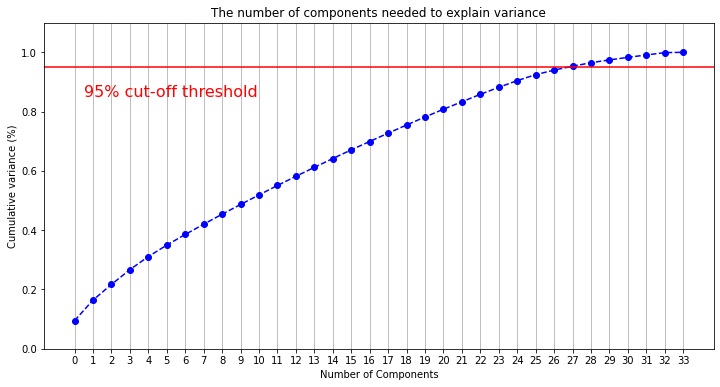

In [4]:
#####################################PCA##########################################
#Part-3

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#generating PCA for all 34 input features
pca = PCA(n_components=(34))
pca_val = pca.fit_transform(df_scale[:,:-1])   #fitting

#The following code constructs the Scree plot
plt.rcParams["figure.figsize"] = (12,6)
fig, ax = plt.subplots()
xi = np.arange(0, 34, step=1)
y = np.cumsum(pca.explained_variance_ratio_)
plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 34, step=1)) 
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)
ax.grid(axis='x')
plt.show()

In [6]:
#from the screeplot we got a insight that 0-27 features are needed to get 95% of the data
#selecting only first 28 PCA's
pca_val = pd.DataFrame(pca_val)
name=[]
for i in range(1,35):
    a="PCA"+str(i)
    name.append(a)
pca_val.columns =name 
pca_final = pd.concat([pca_val.iloc[:,:28],final_df.Renewal], axis = 1)

#cleaning memeory
del(a,ax,fig,i,name,pca,pca_val,xi,y)

In [7]:
########################Splitting the data ################### 
#Part-4

#splitting the data into train and test
X = pca_final.iloc[:,:-1] # Predictors 
Y = pca_final.iloc[:,-1] # Target

In [8]:
#######################Grid Search for KNN##################################
#Part-6
'''Since GridSearch-Cross_Validation uses K-Fold 
there is no need to create seperate Train and Test data,
Predictors and Target of full dataset will be passed'''
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV

#decalring a model instance
knn = KNeighborsClassifier()
svm = SVC()
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
lr = LogisticRegression()
gnb = GaussianNB()

#creating list of models
model_all = [knn , svm , rf , dt , lr , gnb]

#decalring parameters for hyper tuning
param1 = {"n_neighbors":[3,5,7,9,11,13,15,17,19,21],
          "weights":['uniform','distance'],
          "metric":['euclidean','manhattan']}

param2 = {'C': [0.1,1, 10, 100],
          'gamma': [1,0.1,0.01,0.001],
          'kernel': ['rbf', 'poly', 'sigmoid']}
param3 = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

param4 = { 'criterion':['gini','entropy'],
          'max_depth': np.arange(3, 15)}

param5 = {'penalty': ['l1', 'l2'],
          'C':[0.001,.009,0.01,.09,1,5,10,25]}

param6 = {
    'var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]
}

#creating list of parameters
model_param =[param1, param2, param3, param4 , param5 , param6]

#Creating a string names for all the models, later used to campare model performance
model_log = ["_knn", "_svm", "_rf", "_dt" , "_lr" , "_gnb"]

#creating empty df
Grid_knn = Grid_svm = Grid_rf = Grid_dt = Grid_lr = Grid_gnb = pd.DataFrame()

In [9]:
#######################GridSearch-Cross_Validation function#################
#Part-7
#creating k-fold of 10
for i in range(len(model_all)):
    Grid=GridSearchCV(estimator=model_all[i], param_grid=model_param[i], 
                      n_jobs=-1, cv=10, verbose=3 ).fit(X,Y)
    globals()['Grid%s' % model_log[i]]=pd.DataFrame(Grid.cv_results_)

    '''above loop creates dataframes for all possible combinations of models having columns named mean test scores 
and ranking(ranking for mean test scores) '''

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 244 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   24.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 10 folds for each of 288 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 1564 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done 2044 tasks      | elapsed: 31.4min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 39.3min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 44.4min finished


Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.6s finished


In [10]:

#selecting rank 1 model in each dataset
best_knn = Grid_knn[['mean_test_score' , 'rank_test_score']].query('rank_test_score== 1')
best_svm = Grid_svm[['mean_test_score' , 'rank_test_score']].query('rank_test_score== 1')
best_rf = Grid_rf[['mean_test_score' , 'rank_test_score']].query('rank_test_score== 1')
best_dt = Grid_dt[['mean_test_score' , 'rank_test_score']].query('rank_test_score== 1')
best_lr = Grid_lr[['mean_test_score' , 'rank_test_score']].query('rank_test_score== 1')
best_gnb = Grid_gnb[['mean_test_score' , 'rank_test_score']].query('rank_test_score== 1')

#printing test accuracy for all best models
print("Test accuracy for best KNeighborsClassifier model:",format(100*best_knn.iloc[0,0],".2f"),"%")
print("Test accuracy for best SVC model:",format(100*best_svm.iloc[0,0],".2f"),"%")
print("Test accuracy for best RandomForestClassifier model:",format(100*best_rf.iloc[0,0],".2f"),"%")
print("Test accuracy for best DecisionTreeClassifier model:",format(100*best_dt.iloc[0,0],".2f"),"%")
print("Test accuracy for best LogisticRegression model:",format(100*best_lr.iloc[0,0],".2f"),"%")
print("Test accuracy for best GaussianNB model:",format(100*best_gnb.iloc[0,0],".2f"),"%")

Test accuracy for best KNeighborsClassifier model: 52.90 %
Test accuracy for best SVC model: 51.90 %
Test accuracy for best RandomForestClassifier model: 52.10 %
Test accuracy for best DecisionTreeClassifier model: 51.00 %
Test accuracy for best LogisticRegression model: 48.60 %
Test accuracy for best GaussianNB model: 50.10 %
